# World Wide Products Inc.

## Introduction


In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [232]:
df=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-5-Khan/Data/RawData/HistoricalProductDemand.csv")
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [233]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [234]:
#new = df["Product_Code"].str.split("_", n = 1, expand = True)
#df["Code"]=new[1]

In [235]:
#new = df["Product_Category"].str.split("_", n = 1, expand = True)
#df["Category"]=new[1]
#df.head()

In [236]:
#df['Code'] = df['Code'].astype('float')
#df['Category'] = df['Category'].astype('float')
df['Warehouse'] = df['Warehouse'].astype('string')
df['Date'] = df['Date'].astype('string')
df['Product_Category'] = df['Product_Category'].astype('string')
df['Product_Code'] = df['Product_Code'].astype('string')
df.dtypes

Product_Code        string
Warehouse           string
Product_Category    string
Date                string
Order_Demand        object
dtype: object

In [237]:
df['Order_Demand'] = df['Order_Demand'].astype('string')

In [238]:
df.Order_Demand = df.Order_Demand.str.strip()

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  string
 1   Warehouse         1048575 non-null  string
 2   Product_Category  1048575 non-null  string
 3   Date              1037336 non-null  string
 4   Order_Demand      1048575 non-null  string
dtypes: string(5)
memory usage: 40.0 MB


In [240]:
df.dropna(subset = ["Date"], inplace=True)
#df['Date']=df['Date'].str.replace("/","").astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1037336 non-null  string
 1   Warehouse         1037336 non-null  string
 2   Product_Category  1037336 non-null  string
 3   Date              1037336 non-null  string
 4   Order_Demand      1037336 non-null  string
dtypes: string(5)
memory usage: 47.5 MB


In [241]:
df=df.reset_index()
df.drop(columns =["index"], inplace = True)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [242]:
count=0
for i in range(0,len(df['Order_Demand'])):
    if("(" in df['Order_Demand'][i]):
        df['Order_Demand'][i] = df['Order_Demand'][i].rstrip(")")
        df['Order_Demand'][i] = df['Order_Demand'][i].lstrip("(")
        df['Order_Demand'][i] = "-" + df['Order_Demand'][i]
        count=count+1
        #df.drop([i], inplace=True, axis=0)
        if(count<3):
            print(df.iloc[i])
            
print('Times Order_Demand variable is negative =', count)

Product_Code        Product_2169
Warehouse                 Whse_A
Product_Category    Category_024
Date                    2012/8/9
Order_Demand                  -1
Name: 112289, dtype: string
Product_Code        Product_2132
Warehouse                 Whse_A
Product_Category    Category_009
Date                   2012/11/1
Order_Demand                 -24
Name: 112306, dtype: string
Times Order_Demand variable is negative = 5899


In [243]:
df['Order_Demand'] = df['Order_Demand'].astype('float')

In [244]:
count=0
for i in range(0,len(df['Order_Demand'])):
    if(df['Order_Demand'][i] < 0):
        #print(df.iloc[i])
        #df.drop([i],inplace=True, axis=0)
        df['Order_Demand'][i] = (df['Order_Demand'][i])*(-1)
        count=count+1
        
            
print('Times Order_Demand variable is negative =', count)

<ipython-input-244-5b9b71c14f8d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order_Demand'][i] = (df['Order_Demand'][i])*(-1)


Times Order_Demand variable is negative = 5899


In [245]:
df.dtypes

Product_Code         string
Warehouse            string
Product_Category     string
Date                 string
Order_Demand        float64
dtype: object

In [246]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [247]:
df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100.0
2012-01-19,Product_0979,Whse_J,Category_028,500.0
2012-02-03,Product_0979,Whse_J,Category_028,500.0
2012-02-09,Product_0979,Whse_J,Category_028,500.0
2012-03-02,Product_0979,Whse_J,Category_028,500.0


In [248]:
dfProd=df.query("Product_Code == 'Product_0704'")[['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand']]
dfProd.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-03-02,Product_0704,Whse_J,Category_001,1.0
2012-01-17,Product_0704,Whse_J,Category_001,10.0
2012-02-14,Product_0704,Whse_J,Category_001,10.0
2012-03-07,Product_0704,Whse_J,Category_001,10.0
2012-05-15,Product_0704,Whse_J,Category_001,10.0


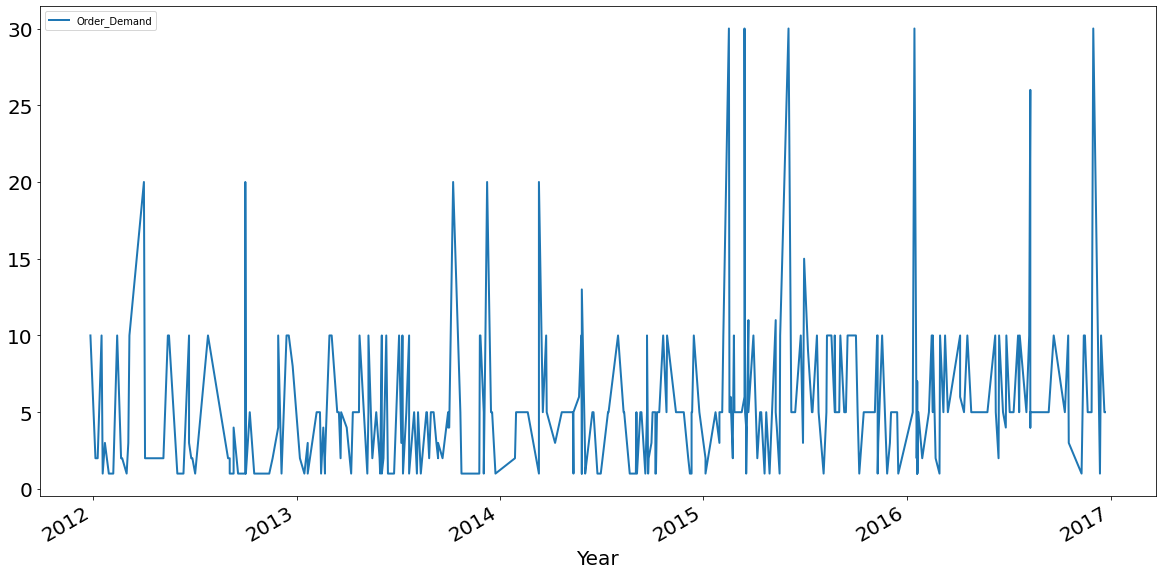

In [256]:
dfProd.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

#ax = plt.gca()

#dfProd.plot(kind='line',x='Date',y='Order_Demand', figsize=(20,10), ax=ax)

#plt.title('Product 0704')
#plt.xlabel('Date')
#plt.ylabel('Demand')

#plt.show()

In [250]:
df

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100.0
2012-01-19,Product_0979,Whse_J,Category_028,500.0
2012-02-03,Product_0979,Whse_J,Category_028,500.0
2012-02-09,Product_0979,Whse_J,Category_028,500.0
2012-03-02,Product_0979,Whse_J,Category_028,500.0
...,...,...,...,...
2016-04-27,Product_1791,Whse_J,Category_006,1000.0
2016-04-27,Product_1974,Whse_J,Category_006,1.0
2016-04-28,Product_1787,Whse_J,Category_006,2500.0


In [252]:
dfProd2=df.query("Product_Code == 'Product_0979'")[['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand']]
dfProd2.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-19,Product_0979,Whse_J,Category_028,500.0
2012-02-03,Product_0979,Whse_J,Category_028,500.0
2012-02-09,Product_0979,Whse_J,Category_028,500.0
2012-03-02,Product_0979,Whse_J,Category_028,500.0
2012-04-19,Product_0979,Whse_J,Category_028,500.0


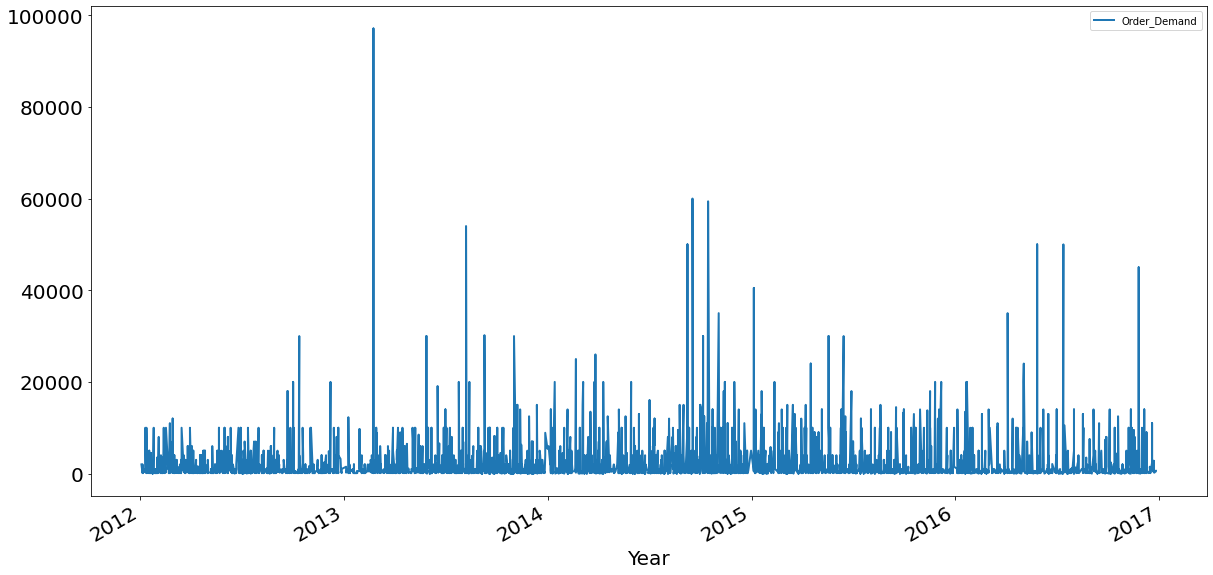

In [257]:
dfProd2.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
#ax = plt.gca()

#dfProd2.plot(kind='line',x='Date',y='Order_Demand', figsize=(20,10), ax=ax)

#plt.title('Product 0979')
#plt.xlabel('Date')
#plt.ylabel('Demand')

#plt.show()

In [271]:
dfProd_check=dfProd[['Order_Demand']]
dfProd2_check=dfProd2[['Order_Demand']]

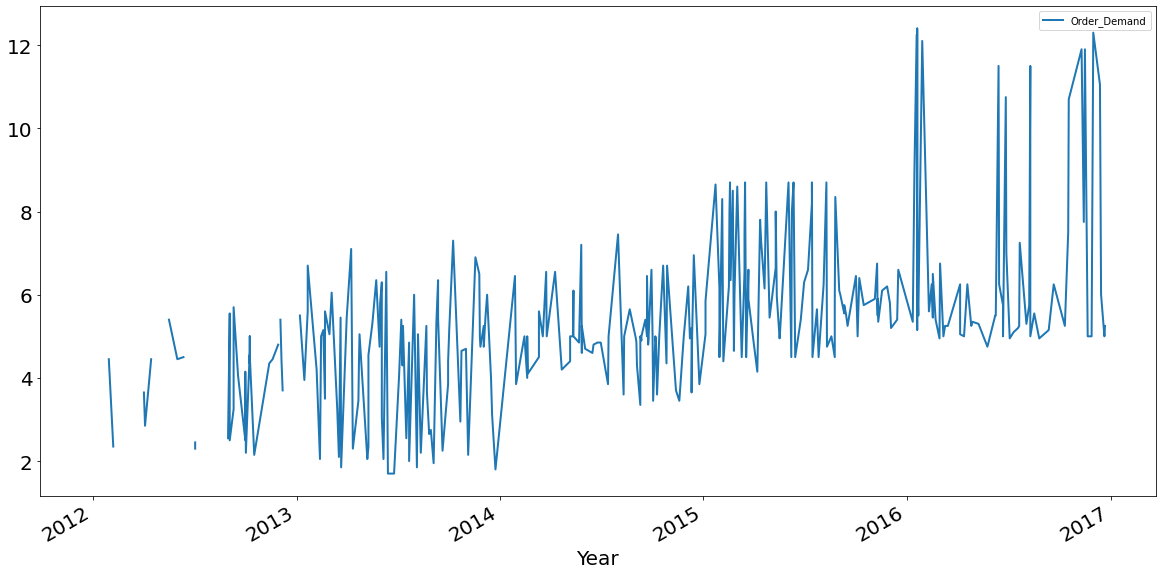

In [305]:
dfProd_check.rolling(20).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [290]:
result = adfuller(dfProd_check['Order_Demand'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.310951310856493
p-value: 0.0004252098426042608
Critical Values:
	1%: -3.450081345901191
	5%: -2.870232621465807
	10%: -2.571401168202517


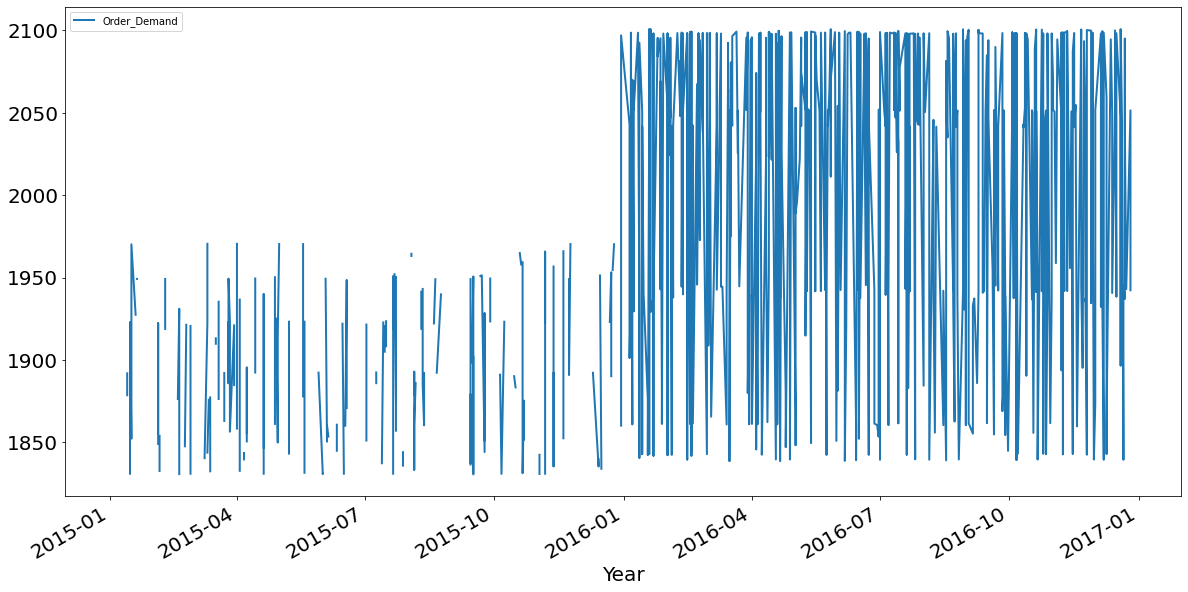

In [311]:
dfProd2_check.rolling(3000).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [291]:
result = adfuller(dfProd2['Order_Demand'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -11.307303787535423
p-value: 1.2639932496515664e-20
Critical Values:
	1%: -3.43203824459253
	5%: -2.8622859739495463
	10%: -2.5671670910000524


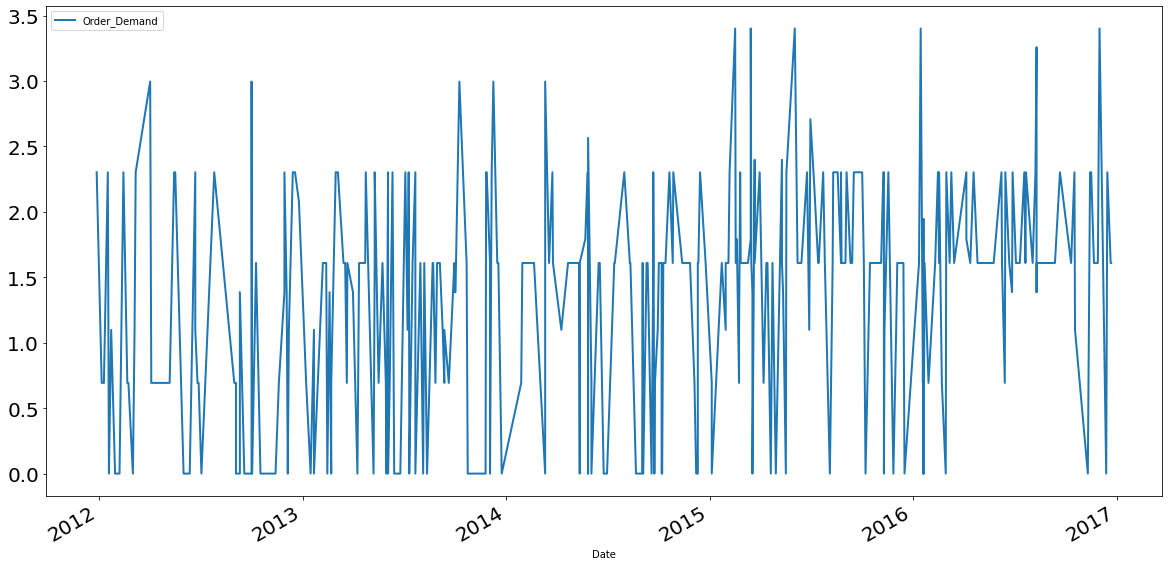

In [294]:
df_log = np.log(dfProd_check)
df_log.plot(figsize=(20,10), linewidth=2, fontsize=20)

In [296]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)

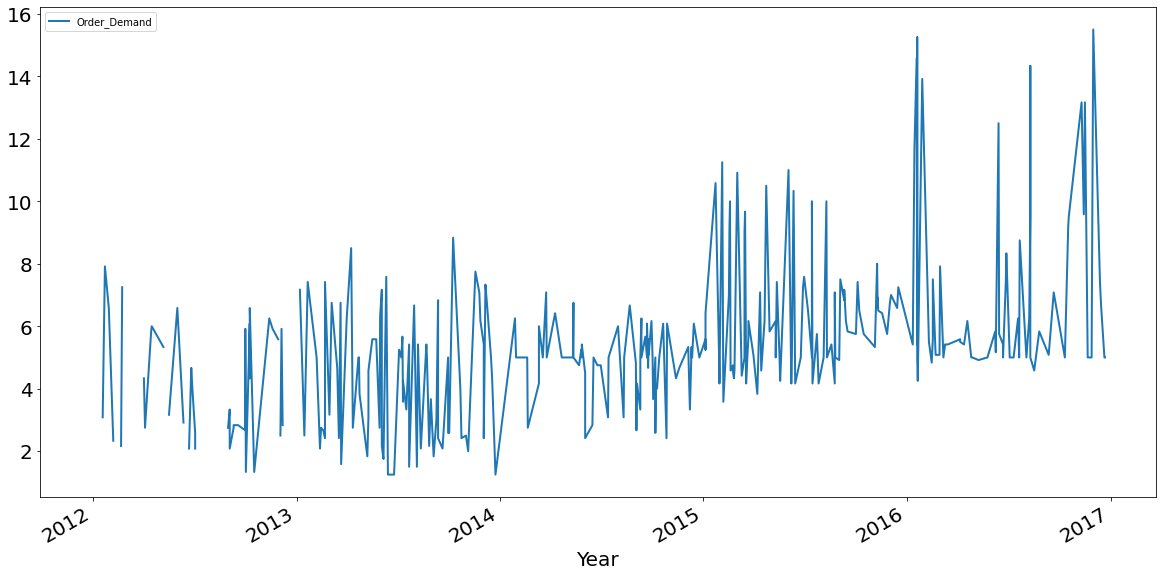